In [10]:
import pandas as pd
from typing import List, Dict, Any
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

In [11]:
url_restauration = "https://www.pxweb.bfs.admin.ch/sq/ac42fe01-72e8-4c55-9ab2-b997e87b1fa1"
url_population = "https://www.pxweb.bfs.admin.ch/sq/a2f3f03c-3b76-4dc0-890e-c6534d341848"

In [12]:
def restauration_employement_to_population_ratio(url_restauration : str, url_population : str) -> pd.DataFrame:
    df_restauration = pd.read_csv(url_restauration, encoding="ANSI")
    df_population = pd.read_csv(url_population, encoding="ANSI")
    df_population = df_population.groupby(["Année", "Sexe"], as_index=False)["Effectif au 1er janvier"].agg("sum")
    
    years : List[int] = [i for i in range(2010, 2025) for _ in range(8)]
    quarters : List[int] = [i for _ in range(15*2) for i in range(1, 5)]
    female : List[int] = [i for _ in range(15) for i in [1]*4+[0]*4]  # 1 if female, 0 if male
    indexes_of_columns_to_go : List[int] = [2+i for j in range((df_restauration.shape[1]-3)//4) for _ in range(2) for i in range(4*j+1, 4*j+5)] #to search efficiently in the dataframe for having the final dataframe in the right format easily
    y : List[float] = []

    for index, gender, year in zip(indexes_of_columns_to_go, female, years):
        y.append(df_restauration.iloc[gender, index]/df_population.loc[df_population["Année"].eq(year)&df_population["Sexe"].eq("Femme" if gender==1 else "Homme"), "Effectif au 1er janvier"].iat[0]*100)

    dict : Dict[List[Any]] = {"Year" : years,
            "Quarter" : quarters,
            "Employment-to-population Ratio [%]" : y, 
            "Female" : female}
    return pd.DataFrame(dict)

def create_quarter_dummies(df : pd.DataFrame):
    quarter_lists_list = [[], [], [], []]
    for i in range(df.shape[0]):
        for j in range(1, 5):
            if df["Quarter"][i]==j:
                quarter_lists_list[j-1].append(1)
            else:
                quarter_lists_list[j-1].append(0)
    for i in range(4):
        df[f"Q{i+1}"]=quarter_lists_list[i]
    return df

def create_before_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    df["Before_Lockdown"] = [1 if i<80 else 0 for i in range(df.shape[0])]
    return df

def create_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    indexes = [i for i in range(80, 98)]
    indexes.extend([100, 101])
    dummy_list = [1 if i in indexes else 0 for i in range(df.shape[0])]
    df["Lockdown"] = dummy_list
    return df

def create_after_lockdown_dummies(df: pd.DataFrame) -> pd.DataFrame:
    indexes_list = [98, 99]
    indexes_list.extend(i for i in range(102, df.shape[0]))
    dummy_list = [1 if i in indexes_list else 0 for i in range(df.shape[0])]
    df["After_Lockdown"] = dummy_list
    return df

def create_years_pre_post_dummies(df : pd.DataFrame) -> pd.DataFrame:
    oyb_dummies = [1 if 72<=i<80 else 0 for i in range(df.shape[0])]
    tyb_dummies = [1 if 64<=i<72 else 0 for i in range(df.shape[0])]
    oya_dummies = [1 if i in [98, 99, 102, 103, 104, 105, 108, 109] else 0 for i in range(df.shape[0])]
    tya_dummies = [1 if i in [106, 107, 110, 111, 112, 113, 114, 115] else 0 for i in range(df.shape[0])]
    df["Two_Years_Before"] = tyb_dummies
    df["One_Year_Before"] = oyb_dummies
    df["One_Year_After"] = oya_dummies
    df["Two_Years_After"] = tya_dummies
    return df

def time_dummy(df : pd.DataFrame) -> pd.DataFrame:
    df["time"] = df["Year"].astype(str) + "Q" + df["Quarter"].astype(str)
    return df

def quarter_number(df : pd.DataFrame) -> pd.DataFrame:
    df["N_Quarter"] = (df["Year"] - df["Year"].min())*4 + (df["Quarter"] - 1)
    return df

def dataframe_creator(url_restauration : str, url_population : str) -> pd.DataFrame:
    df = restauration_employement_to_population_ratio(url_restauration, url_population)
    df = create_quarter_dummies(df)
    df = create_lockdown_dummies(df)
    df = create_after_lockdown_dummies(df)
    df = create_years_pre_post_dummies(df)
    df = time_dummy(df)
    df = quarter_number(df)
    return df

In [13]:
df = dataframe_creator(url_restauration, url_population)
df

,Year,Quarter,Employment-to-population Ratio [%],Female,Q1,Q2,Q3,Q4,Lockdown,After_Lockdown,Two_Years_Before,One_Year_Before,One_Year_After,Two_Years_After,time,N_Quarter
0,2010,1,3.103141,1,1,0,0,0,0,0,0,0,0,0,2010Q1,0
1,2010,2,3.084915,1,0,1,0,0,0,0,0,0,0,0,2010Q2,1
2,2010,3,3.088478,1,0,0,1,0,0,0,0,0,0,0,2010Q3,2
3,2010,4,2.990922,1,0,0,0,1,0,0,0,0,0,0,2010Q4,3
4,2010,1,2.482187,0,1,0,0,0,0,0,0,0,0,0,2010Q1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024,4,2.456345,1,0,0,0,1,0,1,0,0,0,1,2024Q4,59
116,2024,1,2.452151,0,1,0,0,0,0,1,0,0,0,0,2024Q1,56
117,2024,2,2.494324,0,0,1,0,0,0,1,0,0,0,0,2024Q2,57
118,2024,3,2.441515,0,0,0,1,0,0,1,0,0,0,0,2024Q3,58


In [14]:
def plot_ratio(df : pd.DataFrame) -> None:
    time = np.linspace(0, 59, 60)
    _, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"], marker="o", label="Male")
    ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"], marker="o", label="Female")
    ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
    ax.axvline(50, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
    ax.axvspan(40, 50, color="grey", alpha=0.2)
    plt.xlim(0, 59)
    plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
    plt.ylabel("Employment-to-population ratio [%]")
    plt.legend()
    plt.grid()
    plt.title("Evolution of the Employment-to-population ratio by genders in the restoration sector between 2010 and 2025")
    plt.show()

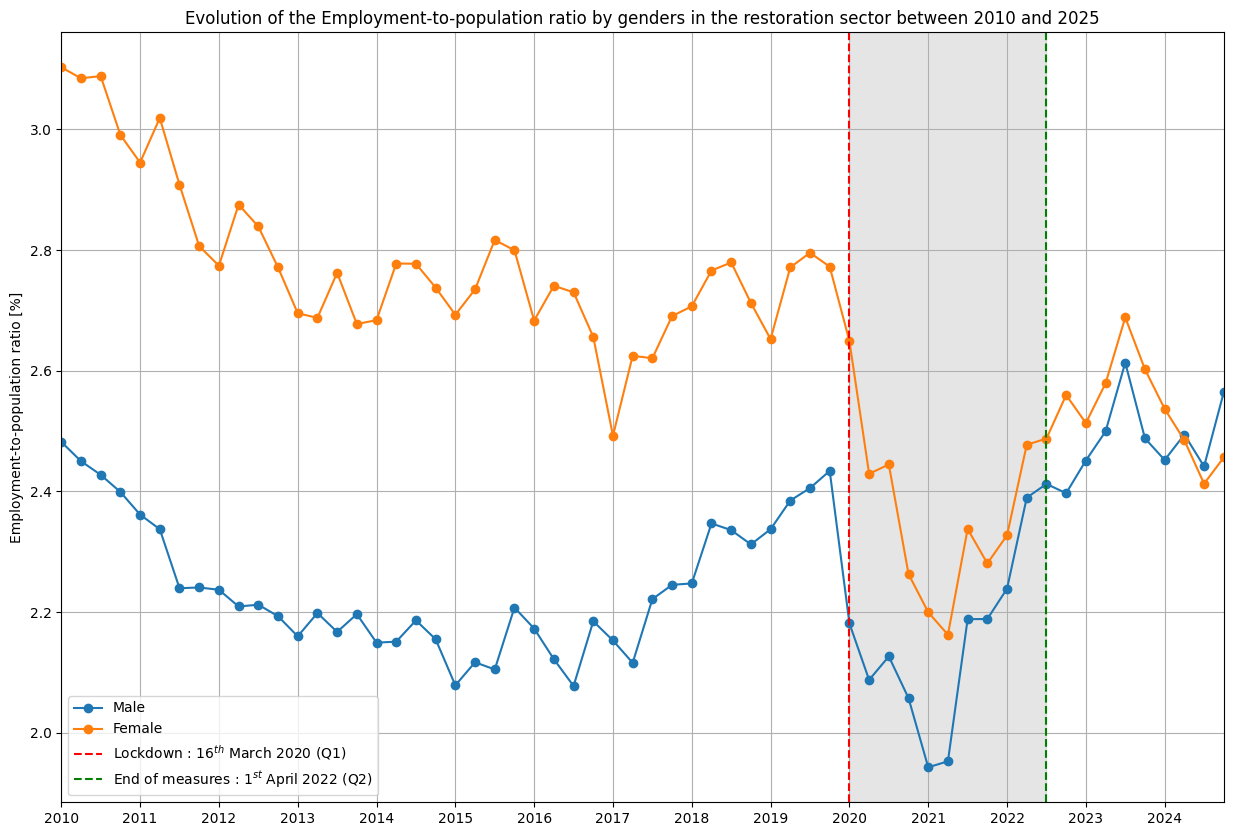

In [15]:
plot_ratio(df)

In [16]:
def plot_comparative(df : pd.DataFrame) -> pd.DataFrame:
    before_covid_female = df.iloc[75, 2]
    before_covid_male = df.iloc[79, 2]
    time = np.linspace(0, 59, 60)
    _, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_male-1, marker="o", label="Male")
    ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_female-1, marker="o", label="Female")
    ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
    ax.axvline(50, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
    ax.axvspan(40, 50, color="grey", alpha=0.2)
    ax.hlines(0, xmin=0, xmax=59, color="k")
    plt.xlim(0, 59)
    plt.ylim(-0.25, 0.15)
    plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
    plt.ylabel("Difference with 2019Q4 [%]")
    plt.legend()
    plt.grid()
    plt.title("Employment-to-population ratio compared to the last quarter before Covid Lockdown by genders in the restoration sector between 2010 and 2025")
    plt.show()

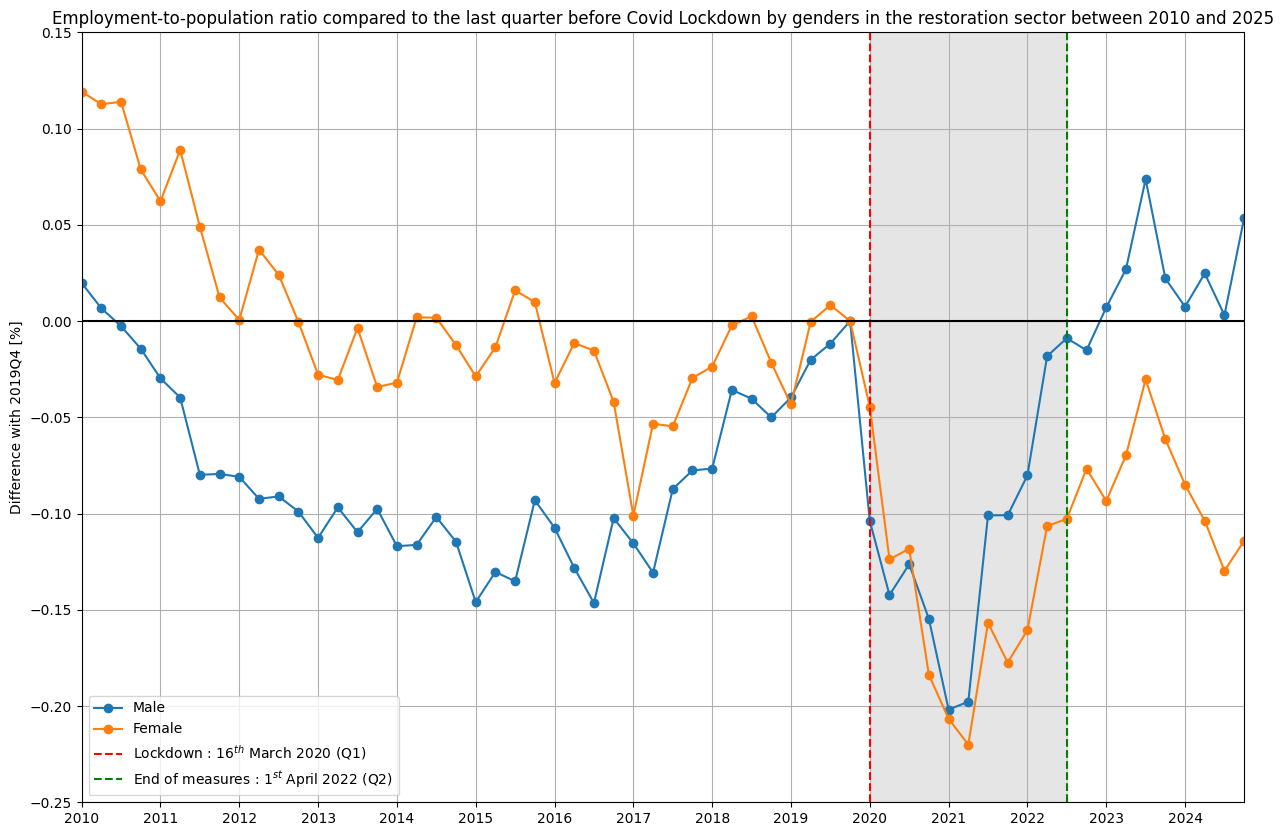

In [17]:
plot_comparative(df)

In [26]:
# df2 = df.copy()

# quarter index (integer time)
# df2["t"] = (df2["Year"] - df2["Year"].min())*4 + (df2["Quarter"] - 1)
# df2["time"] = df2["Year"].astype(str) + "Q" + df2["Quarter"].astype(str)

# Y = 'Q("Employment-to-population Ratio [%]")'

# restrict to pre-pandemic only (<= 2019Q4)
t_real = (2020 - df["Year"].min())*4  # 2020Q1
pre = df[df["N_Quarter"] < t_real].copy()

# pick a placebo start date, e.g. 2017Q1
t_placebo = (2014 - df["Year"].min())*4+2  # 2017Q3 -> 10 quarters (same lenght as Covid-19)
pre["PlaceboPost"] = (pre["N_Quarter"] >= t_placebo).astype(int)

formula_placebo = r"Q('Employment-to-population Ratio [%]') ~ Female + C(time) + Female:PlaceboPost"

m_placebo = smf.ols(formula_placebo, data=pre).fit(cov_type="HAC", cov_kwds={"maxlags": 4})

print(m_placebo.summary())
print("Placebo DiD =", m_placebo.params["Female:PlaceboPost"])

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.976
Model:                                                 OLS   Adj. R-squared:                  0.949
Method:                                      Least Squares   F-statistic:                 1.628e+04
Date:                                   mer., 17 déc. 2025   Prob (F-statistic):           1.11e-70
Time:                                             14:15:21   Log-Likelihood:                 132.60
No. Observations:                                       80   AIC:                            -181.2
Df Residuals:                                           38   BIC:                            -81.15
Df Model:                                               41                                         
Covariance Type:                                       HAC                                         


In [18]:
formula_did_a = r"Q('Employment-to-population Ratio [%]') ~ Female + Lockdown + Female:Lockdown + C(Quarter)"

formula_did_b = r"Q('Employment-to-population Ratio [%]') ~ Female + After_Lockdown + Female:After_Lockdown + C(Quarter)"

In [22]:
print(formula_did_a)
simple_did = smf.ols(formula_did_a, data=df.loc[df["After_Lockdown"]==0]).fit(cov_type="HC1")
print(simple_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Lockdown + Female:Lockdown + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.825
Model:                                                 OLS   Adj. R-squared:                  0.814
Method:                                      Least Squares   F-statistic:                     73.26
Date:                                   mer., 17 déc. 2025   Prob (F-statistic):           4.54e-33
Time:                                             14:14:54   Log-Likelihood:                 67.503
No. Observations:                                      100   AIC:                            -121.0
Df Residuals:                                           93   BIC:                            -102.8
Df Model:                                                6                                         
Covarianc

In [20]:
print(formula_did_b)
simple_did = smf.ols(formula_did_b, data=df.loc[df["Lockdown"]==0]).fit(cov_type="HC1")
print(simple_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + After_Lockdown + Female:After_Lockdown + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.821
Model:                                                 OLS   Adj. R-squared:                  0.810
Method:                                      Least Squares   F-statistic:                     64.15
Date:                                   mer., 17 déc. 2025   Prob (F-statistic):           6.66e-31
Time:                                             14:14:33   Log-Likelihood:                 76.770
No. Observations:                                      100   AIC:                            -139.5
Df Residuals:                                           93   BIC:                            -121.3
Df Model:                                                6                                       

In [23]:
formula_es = r"Q('Employment-to-population Ratio [%]') ~ Female + Two_Years_Before + One_Year_Before + Lockdown + One_Year_After + Two_Years_After + Female:Two_Years_Before + Female:One_Year_Before + Female:Lockdown + Female:One_Year_After + Female:Two_Years_After  + C(Quarter)"

print(formula_es)
eventstudy_did = smf.ols(formula_es, data=df).fit(cov_type="HC1")   #Exclure 2024Q3 et 2024Q4
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Two_Years_Before + One_Year_Before + Lockdown + One_Year_After + Two_Years_After + Female:Two_Years_Before + Female:One_Year_Before + Female:Lockdown + Female:One_Year_After + Female:Two_Years_After  + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.805
Model:                                                 OLS   Adj. R-squared:                  0.779
Method:                                      Least Squares   F-statistic:                     76.25
Date:                                   mer., 17 déc. 2025   Prob (F-statistic):           2.38e-48
Time:                                             14:15:00   Log-Likelihood:                 84.449
No. Observations:                                      120   AIC:                            -138.9
Df Residuals:                       